In [1]:
library(ggplot2)
library(Seurat)
library(plyr)
library(dplyr)
library(Matrix)
library(cowplot)
library(nichenetr)
library(heatmap3)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
adult1.counts <- Read10X("GSM4742854_Adult1_processed")
adult2.counts <- Read10X("GSM4742855_Adult2_processed")
adult3.counts <- Read10X("GSM4742856_Adult3_processed")
young1.counts <- Read10X("GSM4742860_Young1_processed")
young2.counts <- Read10X("GSM4742861_Young2_processed")
young3.counts <- Read10X("GSM4742862_Young3_processed")

adult1.seurat <- CreateSeuratObject(adult1.counts, min.cells = 10, min.features = 100, project = "Adult1")
adult2.seurat <- CreateSeuratObject(adult2.counts, min.cells = 10, min.features = 100, project = "Adult2")
adult3.seurat <- CreateSeuratObject(adult3.counts, min.cells = 10, min.features = 100, project = "Adult3")
young1.seurat <- CreateSeuratObject(young1.counts, min.cells = 10, min.features = 100, project = "Young1")
young2.seurat <- CreateSeuratObject(young2.counts, min.cells = 10, min.features = 100, project = "Young2")
young3.seurat <- CreateSeuratObject(young3.counts, min.cells = 10, min.features = 100, project = "Young3")

dataset.list <- list(Adult1 = adult1.seurat, Adult2 = adult2.seurat, Adult3 = adult3.seurat,
                     Young1 = young1.seurat, Young2 = young2.seurat, Young3 = young3.seurat)

remove(adult1.counts); remove(adult2.counts); remove(adult3.counts)
remove(young1.counts); remove(young2.counts); remove(young3.counts)

remove(adult1.seurat); remove(adult2.seurat); remove(adult3.seurat)
remove(young1.seurat); remove(young2.seurat); remove(young3.seurat)

# Integration

Here we will run the Seurat integration pipeline on the individual samples

In [3]:
dataset.list <- lapply(X = dataset.list, FUN = function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, nfeatures = 2000)
  return(x)
})

int.features <- SelectIntegrationFeatures(object.list = dataset.list, nfeatures = 2000)

heart.anchors <- FindIntegrationAnchors(object.list = dataset.list, 
                                        anchor.features = int.features,
                                        normalization.method = "LogNormalize")
heart.combined.seurat <- IntegrateData(anchorset = heart.anchors)

DefaultAssay(heart.combined.seurat) <- "integrated"

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7654 anchors

Filtering anchors

	Retained 5246 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5144 anchors

Filtering anchors

	Retained 4384 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4835 anchors

Filtering anchors

	Retained 4138 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9932 anchors

Filtering anchors

	Retained 5837 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8247 anchors

Filtering anchors

	Retained 5017 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4996 anchors

Fi

In [4]:
## Run clustering on the integrated data
remove(heart.anchors)
remove(dataset.list)

heart.combined.seurat <- ScaleData(heart.combined.seurat)
heart.combined.seurat <- RunPCA(heart.combined.seurat, verbose = FALSE)
heart.combined.seurat <- RunUMAP(heart.combined.seurat, reduction = "pca", dims = 1:50)

heart.combined.seurat <- FindNeighbors(heart.combined.seurat, reduction = "pca", dims = 1:50)
heart.combined.seurat <- FindClusters(heart.combined.seurat, resolution = 0.8)

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:02:52 UMAP embedding parameters a = 0.9922 b = 1.112

21:02:52 Read 26380 rows and found 50 numeric columns

21:02:52 Using Annoy for neighbor search, n_neighbors = 30

21:02:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:02:56 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmp32q03g/file11298169c96b8

21:02:56 Searching Annoy index using 1 thread, search_k = 3000

21:03:01 Annoy recall = 100%

21:03:01 Co

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26380
Number of edges: 1321481

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9117
Number of communities: 29
Elapsed time: 4 seconds


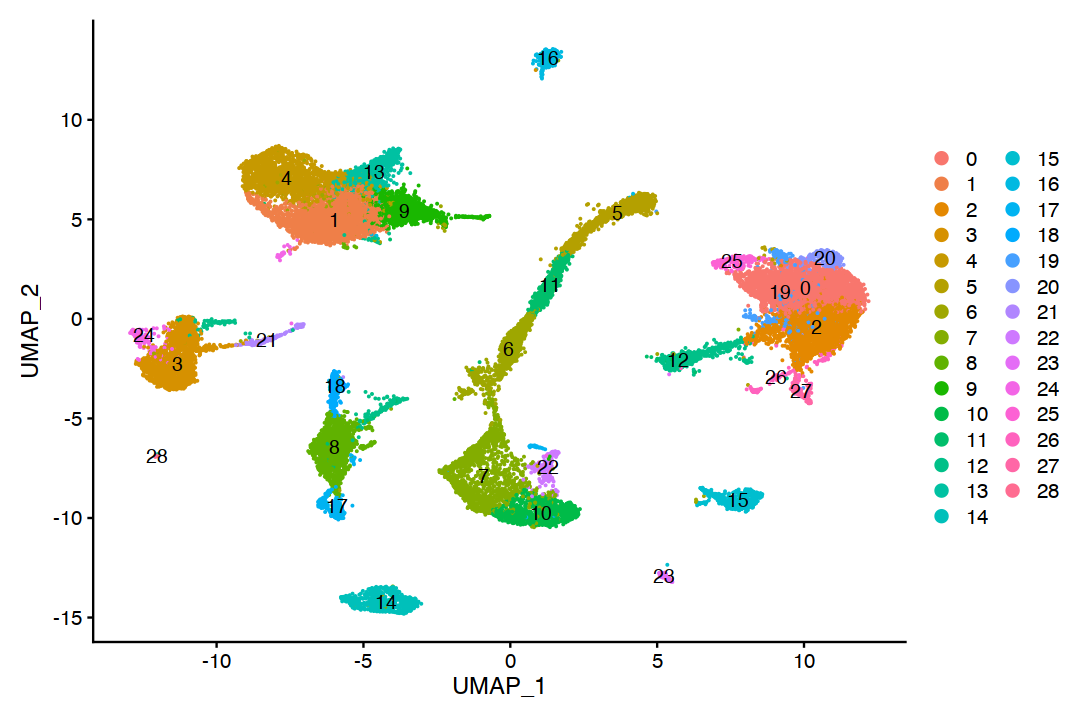

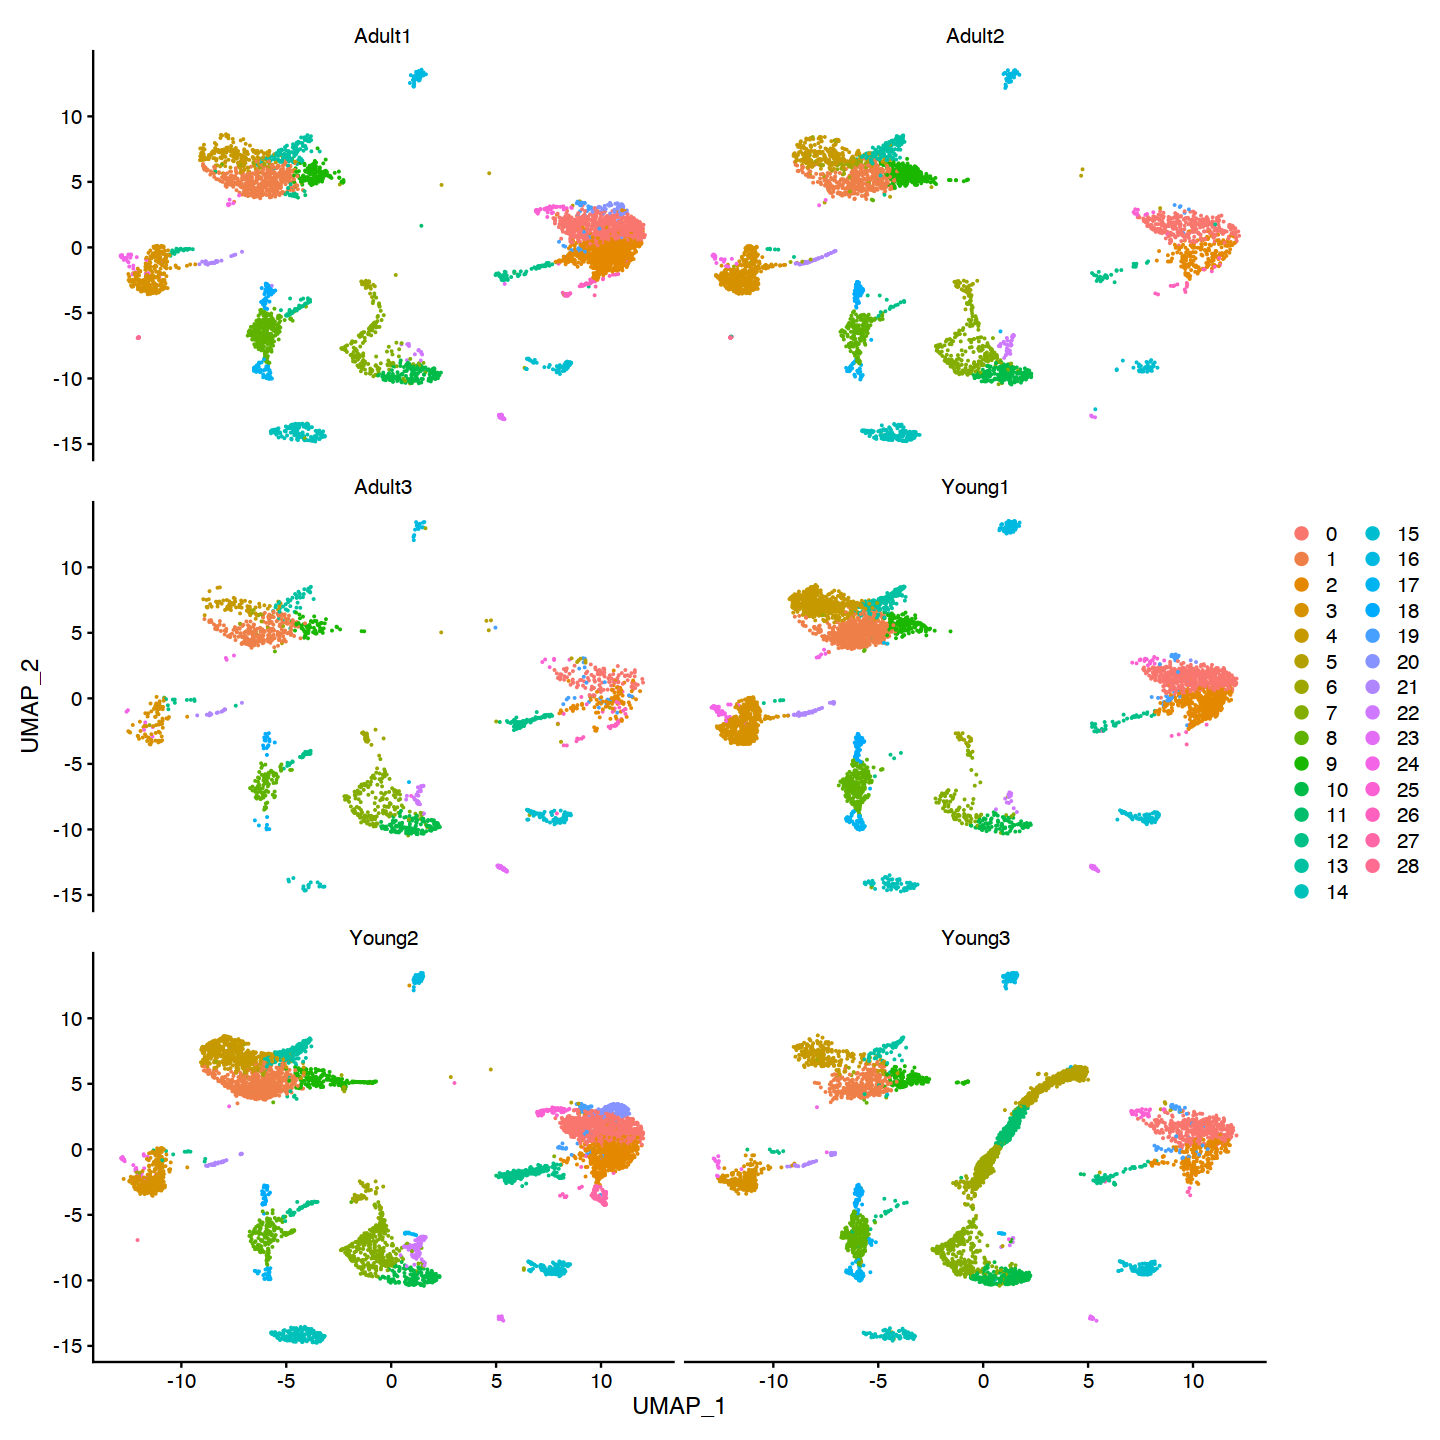

In [5]:
options(repr.plot.width=9, repr.plot.height=6)
DimPlot(heart.combined.seurat, reduction = "umap", label = TRUE) 
options(repr.plot.width=12, repr.plot.height=12)
DimPlot(heart.combined.seurat, reduction = "umap", split.by = "orig.ident", ncol=2)

# Filter out doublets

[1] 25960

[1] 420

[1] 25960


Doublet Singlet 
    420   25960 

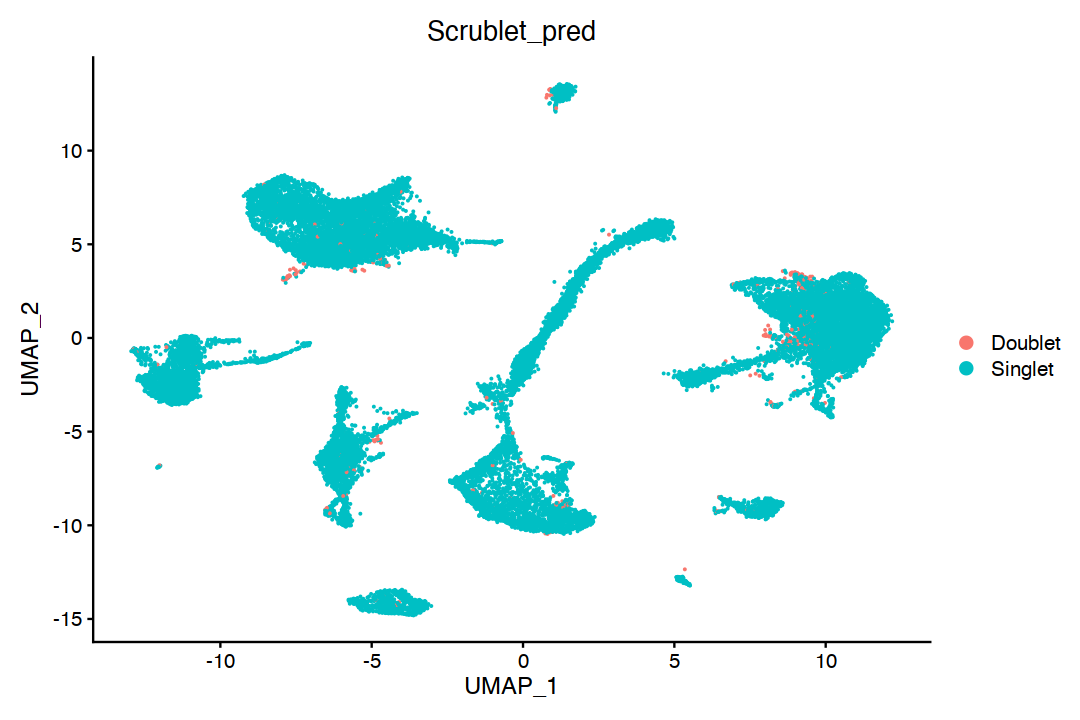

In [6]:
## Read in singlets identified with Scrublet
singlet.files <- c("Scrublet/GSM4742854_Adult1_singlets.txt",
                   "Scrublet/GSM4742855_Adult2_singlets.txt",
                   "Scrublet/GSM4742856_Adult3_singlets.txt",
                   "Scrublet/GSM4742860_Young1_singlets.txt",
                   "Scrublet/GSM4742861_Young2_singlets.txt",
                   "Scrublet/GSM4742862_Young3_singlets.txt")

all.singlets <- c()
for (this.file in singlet.files) {
  singlets <- readLines(this.file)
  all.singlets <- append(all.singlets, singlets)
}
length(all.singlets)

length(setdiff(colnames(heart.combined.seurat), all.singlets))
length(intersect(colnames(heart.combined.seurat), all.singlets))

scrublet.doublet <- ifelse(colnames(heart.combined.seurat) %in% all.singlets, "Singlet", "Doublet")
heart.combined.seurat@meta.data$Scrublet_pred <- scrublet.doublet

table(heart.combined.seurat$Scrublet_pred)
options(repr.plot.width=9, repr.plot.height=6)
DimPlot(heart.combined.seurat, group.by = "Scrublet_pred")

[1]  2000 25960

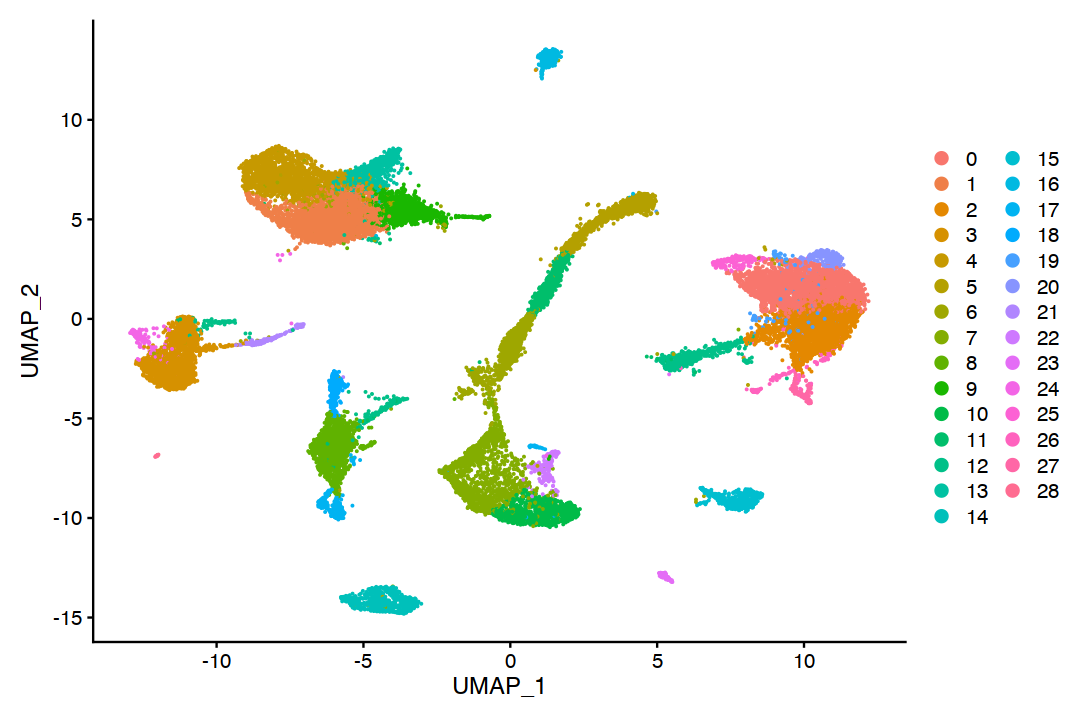

In [7]:
## Filter Seurat object for singlets
heart.combined.seurat <- subset(heart.combined.seurat, Scrublet_pred == "Singlet")
dim(heart.combined.seurat)
DimPlot(heart.combined.seurat)

In [8]:
table(heart.combined.seurat$orig.ident)


Adult1 Adult2 Adult3 Young1 Young2 Young3 
  4258   3335   1664   4311   5424   6968 

In [10]:
## Re-run integration and clustering on singlets
DefaultAssay(heart.combined.seurat) <- "RNA"

dataset.list <- SplitObject(heart.combined.seurat, split.by = "orig.ident")

## Run log-normalization
dataset.list <- lapply(X = dataset.list, FUN = function(x) {
  x <- NormalizeData(x)
  x <- FindVariableFeatures(x, nfeatures = 2000)
  return(x)
})

int.features <- SelectIntegrationFeatures(object.list = dataset.list, nfeatures = 2000)

heart.anchors <- FindIntegrationAnchors(object.list = dataset.list, 
                                        anchor.features = int.features,
                                        normalization.method = "LogNormalize")
heart.combined.seurat <- IntegrateData(anchorset = heart.anchors)

remove(heart.anchors)
remove(dataset.list)


Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 7529 anchors

Filtering anchors

	Retained 5350 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5084 anchors

Filtering anchors

	Retained 4349 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4804 anchors

Filtering anchors

	Retained 4136 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9827 anchors

Filtering anchors

	Retained 5813 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 8106 anchors

Filtering anchors

	Retained 4928 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 4945 anchors

Filtering anchors

	Retained 2614 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9920 anchors

Filtering anchors

	Retained 5384 an

In [11]:
DefaultAssay(heart.combined.seurat) <- "integrated"

heart.combined.seurat <- ScaleData(heart.combined.seurat)
heart.combined.seurat <- RunPCA(heart.combined.seurat, verbose = FALSE)
heart.combined.seurat <- RunUMAP(heart.combined.seurat, reduction = "pca", dims = 1:50)

heart.combined.seurat <- FindNeighbors(heart.combined.seurat, reduction = "pca", dims = 1:50)
heart.combined.seurat <- FindClusters(heart.combined.seurat, resolution = seq(0.2, 0.8, 0.2))

Centering and scaling data matrix

21:46:54 UMAP embedding parameters a = 0.9922 b = 1.112

21:46:54 Read 25960 rows and found 50 numeric columns

21:46:54 Using Annoy for neighbor search, n_neighbors = 30

21:46:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:46:56 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmp32q03g/file112981600bd45

21:46:56 Searching Annoy index using 1 thread, search_k = 3000

21:47:01 Annoy recall = 100%

21:47:03 Commencing smooth kNN distance calibration using 1 thread

21:47:04 Initializing from normalized Laplacian + noise

21:47:06 Commencing optimization for 200 epochs, with 1203280 positive edges

21:47:20 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25960
Number of edges: 1318643

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9672
Number of communities: 16
Elapsed time: 4 seconds


1 singletons identified. 15 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25960
Number of edges: 1318643

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9437
Number of communities: 19
Elapsed time: 4 seconds


1 singletons identified. 18 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25960
Number of edges: 1318643

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9250
Number of communities: 26
Elapsed time: 4 seconds


1 singletons identified. 25 final clusters.



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25960
Number of edges: 1318643

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9110
Number of communities: 28
Elapsed time: 4 seconds


1 singletons identified. 27 final clusters.



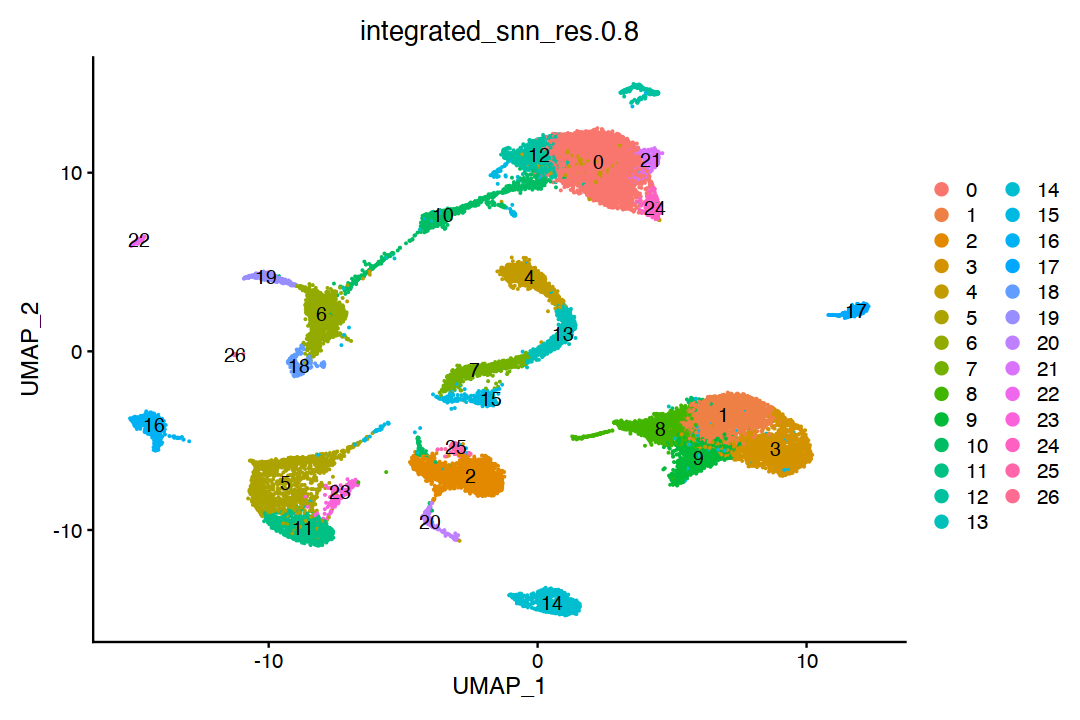

In [15]:

options(repr.plot.width=9, repr.plot.height=6)
heart.combined.seurat$integrated_snn_res.0.8 <- factor(heart.combined.seurat$integrated_snn_res.0.8, 
                                                       levels = as.character(seq(0, 26)))
DimPlot(heart.combined.seurat, label = TRUE, group.by = "integrated_snn_res.0.8")

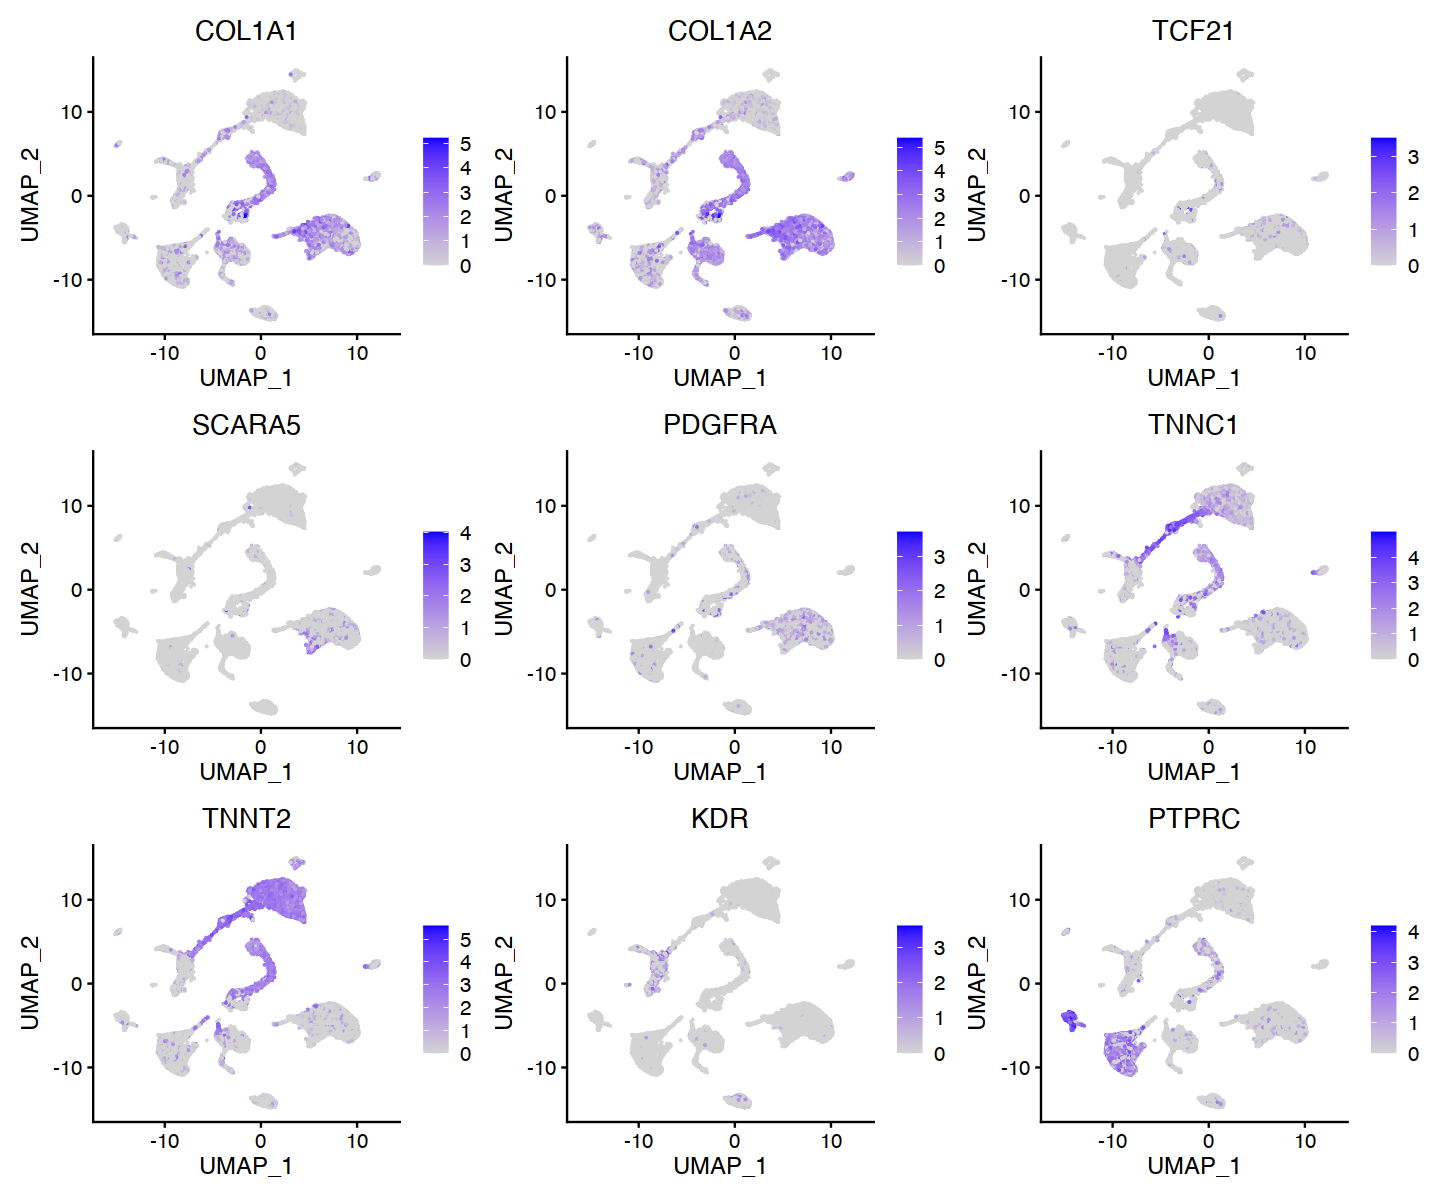

In [22]:
DefaultAssay(heart.combined.seurat) <- "RNA"
options(repr.plot.width=12, repr.plot.height=10)
FeaturePlot(heart.combined.seurat, c("COL1A1", "COL1A2", "TCF21", "SCARA5", "PDGFRA", "TNNC1", "TNNT2", "KDR", "PTPRC"))

# Select fibroblasts

In [23]:
Idents(heart.combined.seurat) <- heart.combined.seurat$integrated_snn_res.0.8
fibroblasts.integrated <- subset(heart.combined.seurat, ident = c("1", "3", "8", "9"))

DefaultAssay(fibroblasts.integrated) <- "integrated"
fibroblasts.integrated <- RunPCA(fibroblasts.integrated, verbose = FALSE)
fibroblasts.integrated <- RunUMAP(fibroblasts.integrated, reduction = "pca", dims = 1:40)

fibroblasts.integrated <- FindNeighbors(fibroblasts.integrated, reduction = "pca", dims = 1:40)
fibroblasts.integrated <- FindClusters(fibroblasts.integrated, resolution = c(0.2, 0.3, 0.4, 0.5))

Idents(fibroblasts.integrated) <- fibroblasts.integrated$integrated_snn_res.0.4
Idents(fibroblasts.integrated) <- as.factor(as.integer(Idents(fibroblasts.integrated)))

22:00:56 UMAP embedding parameters a = 0.9922 b = 1.112

22:00:56 Read 6351 rows and found 40 numeric columns

22:00:56 Using Annoy for neighbor search, n_neighbors = 30

22:00:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

22:00:56 Writing NN index file to temp file /var/folders/2p/fzztw4ls58lcjyzm918ky5900000gn/T//Rtmp32q03g/file11298699a85cb

22:00:56 Searching Annoy index using 1 thread, search_k = 3000

22:00:57 Annoy recall = 100%

22:00:57 Commencing smooth kNN distance calibration using 1 thread

22:00:58 Initializing from normalized Laplacian + noise

22:00:58 Commencing optimization for 500 epochs, with 300368 positive edges

22:01:06 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6351
Number of edges: 366289

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8725
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6351
Number of edges: 366289

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8442
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6351
Number of edges: 366289

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8161
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6351
Number of edges: 366289

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7901
Number of communities: 6
Elapsed time: 0 seconds


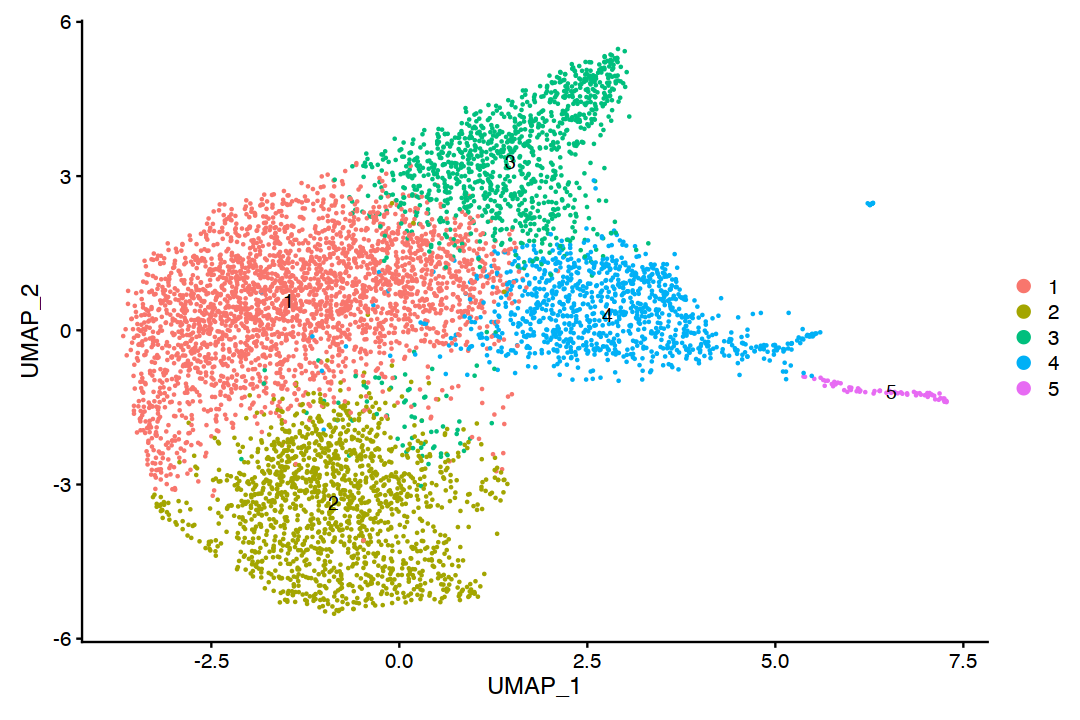

In [24]:
options(repr.plot.width=9, repr.plot.height=6)
Idents(fibroblasts.integrated) <- fibroblasts.integrated$integrated_snn_res.0.4
Idents(fibroblasts.integrated) <- as.factor(as.integer(Idents(fibroblasts.integrated)))
DimPlot(fibroblasts.integrated, label = TRUE)